In [1]:
import sys
repo_path = '/home/micael.verissimo/paper_lzt/exp-connection-hep/'
sys.path.insert(0, repo_path)

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from src.callbacks import sp_index
from src.decorators import Summary
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

2025-04-28 17:01:01.403392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 17:01:01.403429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 17:01:01.404157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 17:01:01.408327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 17:01:03.448553: W tensorflow/compiler/tf2

Welcome to JupyROOT 6.30/02


In [3]:
prefix = "cl_ring_%i"

# rings presample 
presample = [prefix % iring for iring in range(8 // 2)]

# EM1 list
sum_rings = 8
em1 = [prefix % iring for iring in range(sum_rings, sum_rings + (64 // 2))]

# EM2 list
sum_rings = 8 + 64
em2 = [prefix % iring for iring in range(sum_rings, sum_rings + (8 // 2))]

# EM3 list
sum_rings = 8 + 64 + 8
em3 = [prefix % iring for iring in range(sum_rings, sum_rings + (8 // 2))]

# HAD1 list
sum_rings = 8 + 64 + 8 + 8
had1 = [prefix % iring for iring in range(sum_rings, sum_rings + (4 // 2))]

# HAD2 list
sum_rings = 8 + 64 + 8 + 8 + 4
had2 = [prefix % iring for iring in range(sum_rings, sum_rings + (4 // 2))]

# HAD3 list
sum_rings = 8 + 64 + 8 + 8 + 4 + 4
had3 = [prefix % iring for iring in range(sum_rings, sum_rings + (4 // 2))]

col_names = presample + em1 + em2 + em3 + had1 + had2 + had3

In [4]:
# load the data
sgn_df = pd.read_parquet(os.path.join(repo_path, 'data/processed/zee_mb.parquet'))
bkg_df = pd.read_parquet(os.path.join(repo_path, 'data/processed/jf17_mb.parquet'))

m_df = pd.concat([sgn_df, bkg_df], axis=0)


input_cols = [f"cl_ring_{idx}" for idx in range(100)] #col_names #[f"cl_ring_{idx}" for idx in range(100)]

In [5]:
m_df.target.value_counts()

target
1    11984
0    11573
Name: count, dtype: int64

In [6]:
GeV = 1e3
display(m_df.query(f'cl_et < 30*{GeV} & cl_et > 15*{GeV}').target.value_counts().to_frame('N Samples'))

m_df = m_df.query(f'cl_et < 30*{GeV} & cl_et > 15*{GeV}')

,N Samples
target,
0,4697
1,3131


<Axes: >

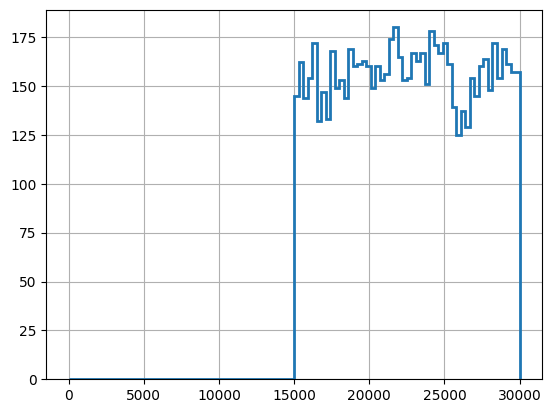

In [7]:
m_df.cl_et.hist(bins=100, range=(0, 30*GeV), histtype='step', lw=2)

In [8]:
def norm1(data):
    norms = np.abs(data.sum(axis=1))
    norms[norms == 0] = 1
    return data / norms[:, None]

# inputs features normalization
X = norm1(m_df[input_cols].values)
y = m_df.target.values

In [9]:
def build_simple_mlp(input_shape: int, n_layers: int, n_units: int) -> tf.keras.Model:
    """
    Builds a simple Multi-Layer Perceptron (MLP) model.

    Args:
        input_shape (int): The number of input features for the model.
        n_layers (int): The number of hidden layers in the MLP.
        n_units (int): The number of neurons in each hidden layer.

    Returns:
        tf.keras.Model: A compiled Keras model with the specified architecture.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name='Input')
    for ilayer in range(n_layers):
        dense = tf.keras.layers.Dense(n_units, activation='relu', name=f'dense_layer_{ilayer}',
                                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=512),
                                      bias_initializer='zeros')(inputs if ilayer == 0 else dense)
    # classification layer
    dense = tf.keras.layers.Dense(1, activation='linear', name='output_for_inference',
                                  kernel_initializer=tf.keras.initializers.GlorotUniform(seed=512),
                                  bias_initializer='zeros')(dense) 
    output = tf.keras.layers.Activation('sigmoid', name='output_for_training')(dense)
    model = tf.keras.Model(inputs, output, name="model")
    return model

def class_weight(target: np.ndarray) -> pd.Series:
    """
    Calculate class weights and sample weights for binary classification.

    Args:
        target (np.ndarray): Array of binary target labels (e.g., 0 and 1).

    Returns:
        pd.Series: A pandas Series containing sample weights for each instance, 
                   with the column name 'weight'.
    """
    classes = np.unique(target)
    # [-1,1] or [0,1]
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
    class_weights = {cl: weights[idx] for idx, cl in enumerate(classes)}
    sample_weight = np.ones_like(target, dtype=np.float32)
    sample_weight[target == 1] = weights[1]
    sample_weight[target != 1] = weights[0]
    return pd.Series(sample_weight).to_frame('weight')


In [10]:
model_bce = build_simple_mlp(input_shape=len(input_cols), n_layers=1, n_units=5)
model_geo = build_simple_mlp(input_shape=len(input_cols), n_layers=1, n_units=5)

2025-04-28 17:01:44.159557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 17:01:44.181950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 17:01:44.182127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
bce_weights = model_bce.get_weights()
geo_weights = model_geo.get_weights()

for ib, ig in zip(bce_weights, geo_weights):
    print(ib.shape, ig.shape)
    if len(ib.shape) == 1:
        print(np.allclose(ib, ig))
    else:
        print(np.allclose(ib, ig, rtol=1e-5, atol=1e-8))

(100, 5) (100, 5)
True
(5,) (5,)
True
(5, 1) (5, 1)
True
(1,) (1,)
True


In [12]:
patience = 50

In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=512)

loss     = 'binary_crossentropy'
opt      = tf.keras.optimizers.Adam(learning_rate=0.001)

decorators = [Summary(detailed=True)]
# create a training history:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    if i > 0:
        continue
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test   = X[test_index] , y[test_index]
    
    
    model_bce.compile(optimizer=opt, 
                  loss=loss, 
                  metrics=['accuracy']
                  )
    
    sp_index_callback = sp_index(validation_data=(x_test, y_test),
                                 patience=patience, verbose=True, save_the_best=True)
    
    bce_history = model_bce.fit(x_train, y_train, epochs=1000,
        batch_size=64,
        verbose=True,
        validation_data=(x_test, y_test),
        sample_weight=class_weight(y_train),
        callbacks=[sp_index_callback],
        shuffle=True
    ).history
    
    for decorator in decorators:
        decorator(bce_history , {'model':model_bce, 'data':(x_train, y_train),  'data_val':(x_test, y_test) })

Epoch 1/1000
1/1 [==============================] - 0s 43ms/step- loss: 0.6398 - accuracy: 0.82


2025-04-28 17:01:55.064 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9803 (fa:0.0299, pd:0.9904), patience: 0
2025-04-28 17:01:55.065 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 2s 5ms/step - loss: 0.6398 - accuracy: 0.8240 - val_loss: 0.6025 - val_accuracy: 0.9515 - max_sp_val: 0.9803 - max_sp_fa_val: 0.0299 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.5516 - accuracy: 0.95


2025-04-28 17:01:55.329 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9813 (fa:0.0277, pd:0.9904), patience: 0
2025-04-28 17:01:55.330 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.5447 - accuracy: 0.9593 - val_loss: 0.5044 - val_accuracy: 0.9642 - max_sp_val: 0.9813 - max_sp_fa_val: 0.0277 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 1.0000
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.4487 - accuracy: 0.96


2025-04-28 17:01:55.580 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9824 (fa:0.0256, pd:0.9904), patience: 0
2025-04-28 17:01:55.580 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.9655 - val_loss: 0.4052 - val_accuracy: 0.9681 - max_sp_val: 0.9824 - max_sp_fa_val: 0.0256 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 2.0000
Epoch 4/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.3534 - accuracy: 0.96


2025-04-28 17:01:55.829 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9824 (fa:0.0256, pd:0.9904), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.3468 - accuracy: 0.9709 - val_loss: 0.3205 - val_accuracy: 0.9693 - max_sp_val: 0.9824 - max_sp_fa_val: 0.0256 - max_sp_pd_val: 0.9904
Epoch 5/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.2765 - accuracy: 0.97


2025-04-28 17:01:56.083 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9829 (fa:0.0277, pd:0.9936), patience: 1
2025-04-28 17:01:56.083 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.2724 - accuracy: 0.9722 - val_loss: 0.2537 - val_accuracy: 0.9745 - max_sp_val: 0.9829 - max_sp_fa_val: 0.0277 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 4.0000
Epoch 6/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.2189 - accuracy: 0.97


2025-04-28 17:01:56.328 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9829 (fa:0.0277, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.2172 - accuracy: 0.9740 - val_loss: 0.2071 - val_accuracy: 0.9745 - max_sp_val: 0.9829 - max_sp_fa_val: 0.0277 - max_sp_pd_val: 0.9936
Epoch 7/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1792 - accuracy: 0.97


2025-04-28 17:01:56.573 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9840 (fa:0.0256, pd:0.9936), patience: 1
2025-04-28 17:01:56.574 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9756 - val_loss: 0.1718 - val_accuracy: 0.9745 - max_sp_val: 0.9840 - max_sp_fa_val: 0.0256 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 6.0000
Epoch 8/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1501 - accuracy: 0.97


2025-04-28 17:01:56.822 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 0
2025-04-28 17:01:56.822 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9771 - val_loss: 0.1466 - val_accuracy: 0.9745 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 7.0000
Epoch 9/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1283 - accuracy: 0.97


2025-04-28 17:01:57.074 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9783 - val_loss: 0.1276 - val_accuracy: 0.9757 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936
Epoch 10/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1128 - accuracy: 0.97


2025-04-28 17:01:57.321 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9787 - val_loss: 0.1133 - val_accuracy: 0.9783 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936
Epoch 11/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0990 - accuracy: 0.97


2025-04-28 17:01:57.577 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9796 - val_loss: 0.1030 - val_accuracy: 0.9783 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0892 - accuracy: 0.97


2025-04-28 17:01:57.829 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 3
2025-04-28 17:01:57.830 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9806 - val_loss: 0.0943 - val_accuracy: 0.9796 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 11.0000
Epoch 13/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0822 - accuracy: 0.98


2025-04-28 17:01:58.086 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9808 - val_loss: 0.0880 - val_accuracy: 0.9796 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936
Epoch 14/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0760 - accuracy: 0.98


2025-04-28 17:01:58.333 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.0754 - accuracy: 0.9815 - val_loss: 0.0827 - val_accuracy: 0.9808 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936
Epoch 15/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0700 - accuracy: 0.98


2025-04-28 17:01:58.592 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9820 - val_loss: 0.0784 - val_accuracy: 0.9821 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936
Epoch 16/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0651 - accuracy: 0.98


2025-04-28 17:01:58.843 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 3
2025-04-28 17:01:58.844 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9827 - val_loss: 0.0750 - val_accuracy: 0.9834 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 15.0000
Epoch 17/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0640 - accuracy: 0.98


2025-04-28 17:01:59.098 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9831 - val_loss: 0.0721 - val_accuracy: 0.9834 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 18/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0595 - accuracy: 0.98


2025-04-28 17:01:59.352 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.9833 - val_loss: 0.0698 - val_accuracy: 0.9834 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 19/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0574 - accuracy: 0.98


2025-04-28 17:01:59.596 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9837 - val_loss: 0.0677 - val_accuracy: 0.9847 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 20/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0553 - accuracy: 0.98


2025-04-28 17:01:59.855 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 3


111/111 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.0661 - val_accuracy: 0.9860 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 21/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0519 - accuracy: 0.98


2025-04-28 17:02:00.108 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 4
2025-04-28 17:02:00.109 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0644 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 20.0000
Epoch 22/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0503 - accuracy: 0.98


2025-04-28 17:02:00.372 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.0636 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 23/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0496 - accuracy: 0.98


2025-04-28 17:02:00.622 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9852 - val_loss: 0.0627 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 24/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0478 - accuracy: 0.98


2025-04-28 17:02:00.880 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9852 - val_loss: 0.0615 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 25/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0451 - accuracy: 0.98


2025-04-28 17:02:01.127 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 3


111/111 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9854 - val_loss: 0.0611 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 26/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0455 - accuracy: 0.98


2025-04-28 17:02:01.382 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 4


111/111 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9855 - val_loss: 0.0603 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 27/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0426 - accuracy: 0.98


2025-04-28 17:02:01.633 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 5


111/111 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9859 - val_loss: 0.0596 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 28/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0437 - accuracy: 0.98


2025-04-28 17:02:01.891 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 6


111/111 [==============================] - 0s 2ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.0593 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 29/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0428 - accuracy: 0.98


2025-04-28 17:02:02.156 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 7


111/111 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9864 - val_loss: 0.0591 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 30/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0429 - accuracy: 0.98


2025-04-28 17:02:02.405 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 8


111/111 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9857 - val_loss: 0.0586 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 31/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0385 - accuracy: 0.98


2025-04-28 17:02:02.655 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 9


111/111 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9864 - val_loss: 0.0584 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 32/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0378 - accuracy: 0.98


2025-04-28 17:02:02.912 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 10


111/111 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 0.0581 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 33/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0383 - accuracy: 0.98


2025-04-28 17:02:03.168 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 11


111/111 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.9864 - val_loss: 0.0578 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 34/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0380 - accuracy: 0.98


2025-04-28 17:02:03.417 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 12
2025-04-28 17:02:03.418 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9868 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 33.0000
Epoch 35/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0387 - accuracy: 0.98


2025-04-28 17:02:03.682 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9868 - val_loss: 0.0576 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 36/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0363 - accuracy: 0.98


2025-04-28 17:02:03.943 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9871 - val_loss: 0.0576 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 37/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0352 - accuracy: 0.98


2025-04-28 17:02:04.207 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0364 - accuracy: 0.9875 - val_loss: 0.0575 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 38/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0378 - accuracy: 0.98


2025-04-28 17:02:04.479 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 3


111/111 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 39/1000
1/1 [==============================] - 0s 12ms/step- loss: 0.0357 - accuracy: 0.98


2025-04-28 17:02:04.733 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 4


111/111 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9871 - val_loss: 0.0576 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 40/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0349 - accuracy: 0.98


2025-04-28 17:02:04.987 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 5


111/111 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9875 - val_loss: 0.0575 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 41/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0350 - accuracy: 0.98


2025-04-28 17:02:05.243 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 6


111/111 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 42/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0341 - accuracy: 0.98


2025-04-28 17:02:05.509 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 7


111/111 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9875 - val_loss: 0.0573 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 43/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0338 - accuracy: 0.98


2025-04-28 17:02:05.762 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 8


111/111 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9877 - val_loss: 0.0574 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 44/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0323 - accuracy: 0.98


2025-04-28 17:02:06.011 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 9


111/111 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9877 - val_loss: 0.0576 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 45/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0335 - accuracy: 0.98


2025-04-28 17:02:06.261 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 10


111/111 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9878 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 46/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0347 - accuracy: 0.98


2025-04-28 17:02:06.513 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 11


111/111 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9877 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 47/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0322 - accuracy: 0.98


2025-04-28 17:02:06.764 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 12


111/111 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 0.0577 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 48/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0321 - accuracy: 0.98


2025-04-28 17:02:07.021 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 13


111/111 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9879 - val_loss: 0.0583 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 49/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0329 - accuracy: 0.98


2025-04-28 17:02:07.276 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 14


111/111 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9882 - val_loss: 0.0579 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 50/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0308 - accuracy: 0.98


2025-04-28 17:02:07.526 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 15


111/111 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.0579 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 51/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0320 - accuracy: 0.98


2025-04-28 17:02:07.778 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 16


111/111 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9878 - val_loss: 0.0579 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 52/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0316 - accuracy: 0.98


2025-04-28 17:02:08.035 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 17


111/111 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9878 - val_loss: 0.0584 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 53/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0317 - accuracy: 0.98


2025-04-28 17:02:08.288 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 18


111/111 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9879 - val_loss: 0.0582 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 54/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0280 - accuracy: 0.98


2025-04-28 17:02:08.543 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 19


111/111 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9882 - val_loss: 0.0584 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 55/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0294 - accuracy: 0.98


2025-04-28 17:02:08.799 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 20


111/111 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9881 - val_loss: 0.0583 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 56/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0268 - accuracy: 0.98


2025-04-28 17:02:09.061 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 21


111/111 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9884 - val_loss: 0.0584 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 57/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0303 - accuracy: 0.98


2025-04-28 17:02:09.309 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 22


111/111 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9882 - val_loss: 0.0585 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 58/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0296 - accuracy: 0.98


2025-04-28 17:02:09.566 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 23


111/111 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9882 - val_loss: 0.0586 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 59/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0297 - accuracy: 0.98


2025-04-28 17:02:09.827 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 24


111/111 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9882 - val_loss: 0.0586 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 60/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0284 - accuracy: 0.98


2025-04-28 17:02:10.076 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 25


111/111 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9888 - val_loss: 0.0587 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 61/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0303 - accuracy: 0.98


2025-04-28 17:02:10.333 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 26


111/111 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9888 - val_loss: 0.0589 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 62/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0311 - accuracy: 0.98


2025-04-28 17:02:10.588 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 27


111/111 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9888 - val_loss: 0.0590 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 63/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0297 - accuracy: 0.98


2025-04-28 17:02:10.837 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 28


111/111 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9888 - val_loss: 0.0590 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 64/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0303 - accuracy: 0.98


2025-04-28 17:02:11.087 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 29


111/111 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9889 - val_loss: 0.0591 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 65/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0294 - accuracy: 0.98


2025-04-28 17:02:11.348 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 30


111/111 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9888 - val_loss: 0.0592 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 66/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0294 - accuracy: 0.98


2025-04-28 17:02:11.600 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 31


111/111 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9895 - val_loss: 0.0591 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 67/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0296 - accuracy: 0.98


2025-04-28 17:02:11.856 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 32


111/111 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.0593 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 68/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0284 - accuracy: 0.98


2025-04-28 17:02:12.108 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 33


111/111 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9888 - val_loss: 0.0595 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 69/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0285 - accuracy: 0.98


2025-04-28 17:02:12.356 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 34


111/111 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9891 - val_loss: 0.0593 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 70/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0298 - accuracy: 0.98


2025-04-28 17:02:12.605 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 35


111/111 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9891 - val_loss: 0.0595 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 71/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0285 - accuracy: 0.98


2025-04-28 17:02:12.859 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 36


111/111 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9889 - val_loss: 0.0593 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 72/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0270 - accuracy: 0.98


2025-04-28 17:02:13.116 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 37


111/111 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9888 - val_loss: 0.0595 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 73/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0294 - accuracy: 0.98


2025-04-28 17:02:13.379 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 38


111/111 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9891 - val_loss: 0.0595 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 74/1000
1/1 [==============================] - 0s 12ms/step- loss: 0.0279 - accuracy: 0.98


2025-04-28 17:02:13.633 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 39


111/111 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9891 - val_loss: 0.0596 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 75/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0294 - accuracy: 0.98


2025-04-28 17:02:13.891 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 40


111/111 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9892 - val_loss: 0.0596 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 76/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0281 - accuracy: 0.98


2025-04-28 17:02:14.149 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 41


111/111 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9889 - val_loss: 0.0596 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 77/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0278 - accuracy: 0.98


2025-04-28 17:02:14.436 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 42


111/111 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9892 - val_loss: 0.0596 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 78/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0280 - accuracy: 0.98


2025-04-28 17:02:14.692 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 43


111/111 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9894 - val_loss: 0.0597 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 79/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0270 - accuracy: 0.98


2025-04-28 17:02:14.954 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 44


111/111 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9891 - val_loss: 0.0598 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 80/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0263 - accuracy: 0.98


2025-04-28 17:02:15.203 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 45


111/111 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9892 - val_loss: 0.0599 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 81/1000
1/1 [==============================] - 0s 16ms/step- loss: 0.0266 - accuracy: 0.98


2025-04-28 17:02:15.468 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 46


111/111 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9895 - val_loss: 0.0598 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 82/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0263 - accuracy: 0.98


2025-04-28 17:02:15.733 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 47


111/111 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9895 - val_loss: 0.0599 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 83/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0283 - accuracy: 0.98


2025-04-28 17:02:15.990 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 48


111/111 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9891 - val_loss: 0.0601 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 84/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0279 - accuracy: 0.98


2025-04-28 17:02:16.241 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 49


111/111 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.9895 - val_loss: 0.0601 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 85/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0262 - accuracy: 0.98


2025-04-28 17:02:16.491 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 50
2025-04-28 17:02:16.492 | INFO     | src.callbacks:on_epoch_end:76 - Stopping the Training by SP...


111/111 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.9896 - val_loss: 0.0602 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873


2025-04-28 17:02:16.493 | INFO     | src.callbacks:on_train_end:84 - Reload the best configuration into the current model...
2025-04-28 17:02:34.823 | INFO     | src.decorators:__call__:74 - Starting the train summary...
2025-04-28 17:02:34.939 | INFO     | src.decorators:__call__:101 - Train samples : Prob. det (0.9901), False Alarm (0.0132), SP (0.9884)
2025-04-28 17:02:34.940 | INFO     | src.decorators:__call__:118 - Validation Samples: Prob. det (0.9904), False Alarm (0.0128), SP (0.9888)
2025-04-28 17:02:34.942 | INFO     | src.decorators:__call__:136 - Operation Samples : Prob. det (0.9901), False Alarm (0.0134), SP (0.9883)
2025-04-28 17:01:54.264507: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f46776cffb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 17:01:54.264535: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-04-28 

In [14]:
def calc_sp(det, fake):
    return np.sqrt( np.sqrt(det*(1-fake)) * (0.5*(det+(1 - fake))) )

def plot_loss_function(loss, val_loss, best_epoch, axis, loss_name='Binary Cross Entropy'):
    #  'solid', 'dashed', 'dashdot', 'dotted'
    axis.plot(loss,       color='black', ls='dashdot', lw=1.2, label='Training Loss')
    axis.plot(val_loss,   color='red', ls='solid', lw=1.2, label='Test Loss')
    axis.axvline(x=best_epoch, color='black', ls='dotted', lw=1.2, label='Best epoch')
    axis.set_ylabel(loss_name)
    axis.set_xlabel(r'$\#$ epochs')
    axis.legend(loc='best')
    axis.grid()
    axis.set_title(f'{loss_name} Loss Evolution')

    
def plot_det(det, best_epoch, axis):
    #  'solid', 'dashed', 'dashdot', 'dotted'
    axis.plot(det,       color='dodgerblue', ls='dashdot', lw=1.2, label='Test Set')
    axis.axvline(x=best_epoch, color='black', ls='dotted', lw=1.2, label='Best epoch')
    axis.set_ylabel('Detection')
    axis.set_xlabel(r'$\#$ epochs')
    axis.legend(loc='best')
    axis.grid()
    axis.set_title('Detection Evolution (Test set)')

def plot_fake(fake, best_epoch, axis):
    #  'solid', 'dashed', 'dashdot', 'dotted'
    axis.plot(fake,       color='darkred', ls='dashdot', lw=1.2, label='Test Set')
    axis.axvline(x=best_epoch, color='black', ls='dotted', lw=1.2, label='Best epoch')
    axis.set_ylabel('Fake Rate')
    axis.set_xlabel(r'$\#$ epochs')
    axis.legend(loc='best')
    axis.grid()
    axis.set_title('Fake Rate Evolution (Test set)')

def plot_sp(sp_index, best_epoch, axis):
    #  'solid', 'dashed', 'dashdot', 'dotted'
    axis.plot(sp_index,       color='forestgreen', ls='dashdot', lw=1.2, label='Test Set')
    axis.axvline(x=best_epoch, color='black', ls='dotted', lw=1.2, label='Best epoch')
    axis.set_ylabel(r'$SP$ Index')
    axis.set_xlabel(r'$\#$ epochs')
    axis.legend(loc='best')
    axis.grid()
    axis.set_title(r'$SP$ Index Evolution (Test set)')

def plot_roc_curve(roc_fa, roc_pd, reference_dict, axis, ylim=[75, 105], xlim=[-.5, 50]):

    axis.plot(roc_fa*100, roc_pd*100, color='black', linewidth=1.5, ls='dashed')
    axis.set_ylabel('Probability of Dectection $[\%]$')
    axis.set_xlabel('Fake Rate $[\%]$')

    sp_max_index = np.argmax(calc_sp(roc_pd, roc_fa))

    axis.plot(roc_fa[sp_max_index]*100, roc_pd[sp_max_index]*100, '*', 
                 label=r'$SP_{max}$',
                 markersize=10, color=plt.cm.tab10(4))

    axis.set_ylim(ylim)
    axis.set_xlim(xlim)
    axis.grid()
    axis.legend(loc='best')
    axis.set_title('ROC Curve (Test Set)')

def plot_nn_histogram(hist_dict, reference_dict, axis, threshold=None):
        axis.hist(hist_dict['val_bkg'][1][:-1], hist_dict['val_bkg'][1], weights=hist_dict['val_bkg'][0], histtype='bar', 
                     color='slategray', lw=1.5, 
                     label='jets', alpha=.5)
        axis.hist(hist_dict['val_sgn'][1][:-1], hist_dict['val_sgn'][1], weights=hist_dict['val_sgn'][0], histtype='bar', 
                     color='blue', lw=1.5, 
                     label='electron', alpha=.5)

        if threshold is not None:
            axis.axvline(x=threshold, ls='solid',
                         label=r'$SP_{max}$ Threshold', color='black', lw=1.5)
        colors = iter([plt.cm.tab10(i) for i in range(4)])

        axis.set_title('NN Output Histogram (Test Set)')
        axis.legend(loc='best')
        axis.grid()
        axis.set_yscale('log')
        axis.set_ylabel('Counts')
        axis.set_xlabel('NN Output')

def plot_training_resume(history, output_path, train_tag='Electron-Pion', roc_xlim=[-.5, 35], roc_ylim=[75, 105], loss_name='Binary Cross Entropy'):
    os.makedirs(os.path.join(output_path, f"{train_tag}"), exist_ok=True)
    o_path = os.path.join(output_path, f"{train_tag}")
    #print(o_path)
    # let's moving per sort
    fig, ax  = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(20,10))
    axes     = ax.flatten()
    
    hist_dict        = history['summary']['hists']
    thr_max_sap      = history['summary']['threshold_val']
    roc_pd, roc_fa   = history['summary']['rocs']['roc_val']

    best_epoch       = history['max_sp_best_epoch_val'][-1]
    loss             = history['loss']
    val_loss         = history['val_loss']

    sp_index         = history['max_sp_val']
    det              = history['max_sp_pd_val']
    fake             = history['max_sp_fa_val']


    # plot loss
    plot_loss_function(loss, val_loss, best_epoch, axis=axes[0], loss_name=loss_name)
    # plot roc curve
    plot_roc_curve(roc_fa=roc_fa, roc_pd=roc_pd, reference_dict={}, 
                    axis=axes[1], xlim=roc_xlim, ylim=roc_ylim)
    # plot nn output 
    plot_nn_histogram(hist_dict, reference_dict={}, axis=axes[2], threshold=thr_max_sap)
    # plot the detection
    plot_det(det, best_epoch=best_epoch, axis=axes[3])
    # plot sp index
    plot_sp(sp_index=sp_index, best_epoch=best_epoch, axis=axes[4])
    # plot fake
    plot_fake(fake=fake, best_epoch=best_epoch, axis=axes[5])

    fig.suptitle(r'Train Resume', fontsize=15)
        
    plt.savefig(os.path.join(o_path, 'train_resume.png' ), dpi=150, facecolor='white', bbox_inches='tight')
    fig.clf()
    plt.close()

In [15]:
plot_training_resume(bce_history, output_path=repo_path+'/notebooks', train_tag='zee-jf17-mb', roc_xlim=[-.5, 5], roc_ylim=[0, 105])

# geodesic

In [16]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=512)

def geodesic_loss(y_true, y_pred):
    """
    Geodesic loss function for the neural network.
    """
    # Calculate the geodesic connection
    bce            = tf.keras.losses.BinaryCrossentropy(reduction='none')
    conection      = bce(y_true, y_pred)
    #phi_t          = tf.reduce_sum(conection, axis=-1, keepdims=True)
    #print(conection)
    #print(phi_t)
    exp_connection = tf.math.exp(conection)
    #print(exp_connection)
    
    # Return the sum of the geodesic connection
    return tf.reduce_mean(exp_connection, axis=-1, keepdims=True) - 1

loss     = geodesic_loss
opt      = tf.keras.optimizers.Adam(learning_rate=0.001)


decorators = [Summary(detailed=True)]
# create a training history:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    if i > 0:
        continue
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test   = X[test_index] , y[test_index]
    
    
    model_geo.compile(optimizer=opt, 
                  loss=loss, 
                  metrics=['accuracy']
                  )
    
    sp_index_callback = sp_index(validation_data=(x_test, y_test),
                                 patience=patience, verbose=True, save_the_best=True)
    
    geo_history = model_geo.fit(x_train, y_train, epochs=1000,
        batch_size=64,
        verbose=True,
        validation_data=(x_test, y_test),
        sample_weight=class_weight(y_train),
        callbacks=[sp_index_callback],
        shuffle=True
    ).history
    
    for decorator in decorators:
        decorator(geo_history , {'model':model_geo, 'data':(x_train, y_train),  'data_val':(x_test, y_test) })

Epoch 1/1000
1/1 [==============================] - 0s 29ms/step- loss: 0.9177 - accuracy: 0.88


2025-04-28 17:02:37.788 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9803 (fa:0.0299, pd:0.9904), patience: 0
2025-04-28 17:02:37.789 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 1s 3ms/step - loss: 0.9020 - accuracy: 0.9039 - val_loss: 0.8201 - val_accuracy: 0.9732 - max_sp_val: 0.9803 - max_sp_fa_val: 0.0299 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.7536 - accuracy: 0.97


2025-04-28 17:02:38.047 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9819 (fa:0.0235, pd:0.9873), patience: 0
2025-04-28 17:02:38.048 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.7378 - accuracy: 0.9762 - val_loss: 0.6594 - val_accuracy: 0.9783 - max_sp_val: 0.9819 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9873 - max_sp_best_epoch_val: 1.0000
Epoch 3/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.5972 - accuracy: 0.97


2025-04-28 17:02:38.311 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9835 (fa:0.0235, pd:0.9904), patience: 0
2025-04-28 17:02:38.311 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.9784 - val_loss: 0.5188 - val_accuracy: 0.9783 - max_sp_val: 0.9835 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 2.0000
Epoch 4/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.4659 - accuracy: 0.97


2025-04-28 17:02:38.570 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9835 (fa:0.0235, pd:0.9904), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.9790 - val_loss: 0.4105 - val_accuracy: 0.9808 - max_sp_val: 0.9835 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9904
Epoch 5/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.3729 - accuracy: 0.97


2025-04-28 17:02:38.835 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9835 (fa:0.0235, pd:0.9904), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.3636 - accuracy: 0.9794 - val_loss: 0.3321 - val_accuracy: 0.9821 - max_sp_val: 0.9835 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9904
Epoch 6/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.3022 - accuracy: 0.97


2025-04-28 17:02:39.098 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 2
2025-04-28 17:02:39.098 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.2960 - accuracy: 0.9801 - val_loss: 0.2765 - val_accuracy: 0.9808 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 5.0000
Epoch 7/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.2539 - accuracy: 0.98


2025-04-28 17:02:39.355 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9851 (fa:0.0235, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.2480 - accuracy: 0.9814 - val_loss: 0.2372 - val_accuracy: 0.9821 - max_sp_val: 0.9851 - max_sp_fa_val: 0.0235 - max_sp_pd_val: 0.9936
Epoch 8/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.2150 - accuracy: 0.98


2025-04-28 17:02:39.612 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 1
2025-04-28 17:02:39.613 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.9820 - val_loss: 0.2092 - val_accuracy: 0.9821 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 7.0000
Epoch 9/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.1876 - accuracy: 0.98


2025-04-28 17:02:39.873 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9827 - val_loss: 0.1890 - val_accuracy: 0.9821 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936
Epoch 10/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1726 - accuracy: 0.98


2025-04-28 17:02:40.130 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9861 (fa:0.0213, pd:0.9936), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9830 - val_loss: 0.1750 - val_accuracy: 0.9834 - max_sp_val: 0.9861 - max_sp_fa_val: 0.0213 - max_sp_pd_val: 0.9936
Epoch 11/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1549 - accuracy: 0.98


2025-04-28 17:02:40.395 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 2
2025-04-28 17:02:40.396 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9830 - val_loss: 0.1646 - val_accuracy: 0.9834 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 10.0000
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1425 - accuracy: 0.98


2025-04-28 17:02:40.663 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9834 - val_loss: 0.1577 - val_accuracy: 0.9847 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 13/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.1284 - accuracy: 0.98


2025-04-28 17:02:40.921 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9834 - val_loss: 0.1527 - val_accuracy: 0.9847 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 14/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.1300 - accuracy: 0.98


2025-04-28 17:02:41.175 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0192, pd:0.9936), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.1258 - accuracy: 0.9834 - val_loss: 0.1513 - val_accuracy: 0.9847 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0192 - max_sp_pd_val: 0.9936
Epoch 15/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1210 - accuracy: 0.98


2025-04-28 17:02:41.440 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 3
2025-04-28 17:02:41.440 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.1203 - accuracy: 0.9844 - val_loss: 0.1482 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936 - max_sp_best_epoch_val: 14.0000
Epoch 16/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.1139 - accuracy: 0.98


2025-04-28 17:02:41.699 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0128, pd:0.9873), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.1155 - accuracy: 0.9845 - val_loss: 0.1475 - val_accuracy: 0.9860 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9873
Epoch 17/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1133 - accuracy: 0.98


2025-04-28 17:02:41.962 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9872 (fa:0.0128, pd:0.9873), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.9842 - val_loss: 0.1476 - val_accuracy: 0.9860 - max_sp_val: 0.9872 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9873
Epoch 18/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1122 - accuracy: 0.98


2025-04-28 17:02:42.225 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.1081 - accuracy: 0.9845 - val_loss: 0.1481 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 19/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0995 - accuracy: 0.98


2025-04-28 17:02:42.490 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 3


111/111 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9850 - val_loss: 0.1488 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 20/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1044 - accuracy: 0.98


2025-04-28 17:02:42.745 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 4


111/111 [==============================] - 0s 2ms/step - loss: 0.1024 - accuracy: 0.9851 - val_loss: 0.1503 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 21/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1024 - accuracy: 0.98


2025-04-28 17:02:43.003 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 5


111/111 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9851 - val_loss: 0.1525 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 22/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.1009 - accuracy: 0.98


2025-04-28 17:02:43.260 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 6


111/111 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.9859 - val_loss: 0.1553 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 23/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0965 - accuracy: 0.98


2025-04-28 17:02:43.525 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 7


111/111 [==============================] - 0s 2ms/step - loss: 0.0969 - accuracy: 0.9859 - val_loss: 0.1569 - val_accuracy: 0.9872 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 24/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0898 - accuracy: 0.98


2025-04-28 17:02:43.794 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 8


111/111 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9862 - val_loss: 0.1589 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 25/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0972 - accuracy: 0.98


2025-04-28 17:02:44.056 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 9


111/111 [==============================] - 0s 2ms/step - loss: 0.0933 - accuracy: 0.9858 - val_loss: 0.1610 - val_accuracy: 0.9847 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 26/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0856 - accuracy: 0.98


2025-04-28 17:02:44.312 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 10


111/111 [==============================] - 0s 2ms/step - loss: 0.0918 - accuracy: 0.9862 - val_loss: 0.1643 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 27/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0920 - accuracy: 0.98


2025-04-28 17:02:44.578 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0171, pd:0.9936), patience: 11


111/111 [==============================] - 0s 2ms/step - loss: 0.0908 - accuracy: 0.9867 - val_loss: 0.1694 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0171 - max_sp_pd_val: 0.9936
Epoch 28/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0938 - accuracy: 0.98


2025-04-28 17:02:44.840 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 12


111/111 [==============================] - 0s 2ms/step - loss: 0.0899 - accuracy: 0.9869 - val_loss: 0.1704 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 29/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0898 - accuracy: 0.98


2025-04-28 17:02:45.109 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9878 (fa:0.0149, pd:0.9904), patience: 13


111/111 [==============================] - 0s 2ms/step - loss: 0.0884 - accuracy: 0.9869 - val_loss: 0.1730 - val_accuracy: 0.9860 - max_sp_val: 0.9878 - max_sp_fa_val: 0.0149 - max_sp_pd_val: 0.9904
Epoch 30/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0907 - accuracy: 0.98


2025-04-28 17:02:45.377 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 14
2025-04-28 17:02:45.378 | INFO     | src.callbacks:on_epoch_end:68 - save the best configuration here...


111/111 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9868 - val_loss: 0.1767 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904 - max_sp_best_epoch_val: 29.0000
Epoch 31/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0906 - accuracy: 0.98


2025-04-28 17:02:45.637 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 0


111/111 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9869 - val_loss: 0.1822 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 32/1000
1/1 [==============================] - 0s 12ms/step- loss: 0.0872 - accuracy: 0.98


2025-04-28 17:02:45.903 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 1


111/111 [==============================] - 0s 2ms/step - loss: 0.0858 - accuracy: 0.9869 - val_loss: 0.1822 - val_accuracy: 0.9847 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 33/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0755 - accuracy: 0.98


2025-04-28 17:02:46.168 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 2


111/111 [==============================] - 0s 2ms/step - loss: 0.0851 - accuracy: 0.9869 - val_loss: 0.1858 - val_accuracy: 0.9834 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 34/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0756 - accuracy: 0.98


2025-04-28 17:02:46.424 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 3


111/111 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.9867 - val_loss: 0.1922 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 35/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0870 - accuracy: 0.98


2025-04-28 17:02:46.679 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 4


111/111 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.9869 - val_loss: 0.1924 - val_accuracy: 0.9847 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 36/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0840 - accuracy: 0.98


2025-04-28 17:02:46.937 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 5


111/111 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9869 - val_loss: 0.1978 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 37/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0837 - accuracy: 0.98


2025-04-28 17:02:47.204 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 6


111/111 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9875 - val_loss: 0.2027 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 38/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0816 - accuracy: 0.98


2025-04-28 17:02:47.455 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 7


111/111 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9879 - val_loss: 0.2028 - val_accuracy: 0.9847 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 39/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0841 - accuracy: 0.98


2025-04-28 17:02:47.709 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 8


111/111 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.9874 - val_loss: 0.2052 - val_accuracy: 0.9834 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 40/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0759 - accuracy: 0.98


2025-04-28 17:02:47.961 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 9


111/111 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9874 - val_loss: 0.2121 - val_accuracy: 0.9872 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 41/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0744 - accuracy: 0.98


2025-04-28 17:02:48.220 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 10


111/111 [==============================] - 0s 2ms/step - loss: 0.0806 - accuracy: 0.9871 - val_loss: 0.2128 - val_accuracy: 0.9834 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 42/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0826 - accuracy: 0.98


2025-04-28 17:02:48.483 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 11


111/111 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9872 - val_loss: 0.2164 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 43/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0833 - accuracy: 0.98


2025-04-28 17:02:48.749 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 12


111/111 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9872 - val_loss: 0.2202 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 44/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0732 - accuracy: 0.98


2025-04-28 17:02:49.008 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 13


111/111 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9877 - val_loss: 0.2273 - val_accuracy: 0.9885 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 45/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0707 - accuracy: 0.98


2025-04-28 17:02:49.261 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 14


111/111 [==============================] - 0s 2ms/step - loss: 0.0783 - accuracy: 0.9879 - val_loss: 0.2260 - val_accuracy: 0.9834 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 46/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0807 - accuracy: 0.98


2025-04-28 17:02:49.518 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9888 (fa:0.0128, pd:0.9904), patience: 15


111/111 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9881 - val_loss: 0.2302 - val_accuracy: 0.9860 - max_sp_val: 0.9888 - max_sp_fa_val: 0.0128 - max_sp_pd_val: 0.9904
Epoch 47/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0780 - accuracy: 0.98


2025-04-28 17:02:49.780 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 16


111/111 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.9882 - val_loss: 0.2360 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 48/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0802 - accuracy: 0.98


2025-04-28 17:02:50.047 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 17


111/111 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9881 - val_loss: 0.2370 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 49/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0699 - accuracy: 0.98


2025-04-28 17:02:50.304 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 18


111/111 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9888 - val_loss: 0.2431 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 50/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0782 - accuracy: 0.98


2025-04-28 17:02:50.562 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 19


111/111 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9885 - val_loss: 0.2430 - val_accuracy: 0.9834 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 51/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0782 - accuracy: 0.98


2025-04-28 17:02:50.815 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 20


111/111 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.9881 - val_loss: 0.2480 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 52/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0760 - accuracy: 0.98


2025-04-28 17:02:51.077 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 21


111/111 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9885 - val_loss: 0.2507 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 53/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0779 - accuracy: 0.98


2025-04-28 17:02:51.331 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 22


111/111 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9882 - val_loss: 0.2533 - val_accuracy: 0.9847 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 54/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0794 - accuracy: 0.98


2025-04-28 17:02:51.586 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 23


111/111 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9885 - val_loss: 0.2567 - val_accuracy: 0.9847 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 55/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0747 - accuracy: 0.98


2025-04-28 17:02:51.849 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 24


111/111 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9889 - val_loss: 0.2591 - val_accuracy: 0.9834 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 56/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0697 - accuracy: 0.98


2025-04-28 17:02:52.113 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 25


111/111 [==============================] - 0s 2ms/step - loss: 0.0748 - accuracy: 0.9886 - val_loss: 0.2634 - val_accuracy: 0.9847 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 57/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0763 - accuracy: 0.98


2025-04-28 17:02:52.368 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 26


111/111 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.9884 - val_loss: 0.2671 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 58/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0718 - accuracy: 0.99


2025-04-28 17:02:52.630 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 27


111/111 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.9891 - val_loss: 0.2705 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 59/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0778 - accuracy: 0.98


2025-04-28 17:02:52.886 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 28


111/111 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9892 - val_loss: 0.2739 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 60/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0753 - accuracy: 0.98


2025-04-28 17:02:53.148 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 29


111/111 [==============================] - 0s 2ms/step - loss: 0.0740 - accuracy: 0.9889 - val_loss: 0.2798 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 61/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0766 - accuracy: 0.98


2025-04-28 17:02:53.412 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 30


111/111 [==============================] - 0s 2ms/step - loss: 0.0732 - accuracy: 0.9891 - val_loss: 0.2811 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 62/1000
1/1 [==============================] - 0s 12ms/step- loss: 0.0738 - accuracy: 0.98


2025-04-28 17:02:53.673 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 31


111/111 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9894 - val_loss: 0.2873 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 63/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0772 - accuracy: 0.98


2025-04-28 17:02:53.937 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 32


111/111 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9891 - val_loss: 0.2895 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 64/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0769 - accuracy: 0.98


2025-04-28 17:02:54.192 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 33


111/111 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9889 - val_loss: 0.2907 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 65/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0752 - accuracy: 0.98


2025-04-28 17:02:54.458 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 34


111/111 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9895 - val_loss: 0.2939 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 66/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0749 - accuracy: 0.98


2025-04-28 17:02:54.713 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 35


111/111 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9891 - val_loss: 0.2972 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 67/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0744 - accuracy: 0.98


2025-04-28 17:02:54.972 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 36


111/111 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9896 - val_loss: 0.3007 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 68/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0737 - accuracy: 0.98


2025-04-28 17:02:55.234 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 37


111/111 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9895 - val_loss: 0.3054 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 69/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0745 - accuracy: 0.98


2025-04-28 17:02:55.501 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 38


111/111 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9886 - val_loss: 0.3071 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 70/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0733 - accuracy: 0.98


2025-04-28 17:02:55.764 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 39


111/111 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9892 - val_loss: 0.3122 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 71/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0731 - accuracy: 0.98


2025-04-28 17:02:56.026 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 40


111/111 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9886 - val_loss: 0.3129 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 72/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0742 - accuracy: 0.98


2025-04-28 17:02:56.281 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 41


111/111 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9895 - val_loss: 0.3155 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 73/1000
1/1 [==============================] - 0s 11ms/step- loss: 0.0728 - accuracy: 0.98


2025-04-28 17:02:56.537 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 42


111/111 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9892 - val_loss: 0.3201 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 74/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0723 - accuracy: 0.98


2025-04-28 17:02:56.792 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 43


111/111 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9894 - val_loss: 0.3246 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 75/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0721 - accuracy: 0.98


2025-04-28 17:02:57.051 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 44


111/111 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9898 - val_loss: 0.3247 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 76/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0625 - accuracy: 0.99


2025-04-28 17:02:57.311 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 45


111/111 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9895 - val_loss: 0.3293 - val_accuracy: 0.9860 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 77/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0724 - accuracy: 0.98


2025-04-28 17:02:57.567 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 46


111/111 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9889 - val_loss: 0.3323 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 78/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0634 - accuracy: 0.98


2025-04-28 17:02:57.822 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 47


111/111 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9892 - val_loss: 0.3349 - val_accuracy: 0.9847 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 79/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0622 - accuracy: 0.99


2025-04-28 17:02:58.081 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 48


111/111 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9895 - val_loss: 0.3373 - val_accuracy: 0.9834 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 80/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0692 - accuracy: 0.98


2025-04-28 17:02:58.338 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 49


111/111 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9892 - val_loss: 0.3400 - val_accuracy: 0.9872 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873
Epoch 81/1000
1/1 [==============================] - 0s 10ms/step- loss: 0.0726 - accuracy: 0.98


2025-04-28 17:02:58.597 | INFO     | src.callbacks:on_epoch_end:63 - val_sp: 0.9883 (fa:0.0107, pd:0.9873), patience: 50
2025-04-28 17:02:58.597 | INFO     | src.callbacks:on_epoch_end:76 - Stopping the Training by SP...


111/111 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9894 - val_loss: 0.3479 - val_accuracy: 0.9885 - max_sp_val: 0.9883 - max_sp_fa_val: 0.0107 - max_sp_pd_val: 0.9873


2025-04-28 17:02:58.598 | INFO     | src.callbacks:on_train_end:84 - Reload the best configuration into the current model...
2025-04-28 17:02:58.601 | INFO     | src.decorators:__call__:74 - Starting the train summary...
2025-04-28 17:02:58.687 | INFO     | src.decorators:__call__:101 - Train samples : Prob. det (0.9901), False Alarm (0.0132), SP (0.9884)
2025-04-28 17:02:58.689 | INFO     | src.decorators:__call__:118 - Validation Samples: Prob. det (0.9904), False Alarm (0.0128), SP (0.9888)
2025-04-28 17:02:58.691 | INFO     | src.decorators:__call__:136 - Operation Samples : Prob. det (0.9901), False Alarm (0.0134), SP (0.9883)


In [17]:
plot_training_resume(geo_history, output_path=repo_path+'/notebooks', train_tag='zee-jf17-mb-geodesic',
                     roc_xlim=[-.5, 5], roc_ylim=[0, 105], loss_name='Geodesic Connection')

In [18]:
bce_history['summary']['threshold_op'], geo_history['summary']['threshold_op']

(0.56608254, 0.45415878)

In [19]:
bce_history['summary']['max_sp_val'], geo_history['summary']['max_sp_val']

(0.9888256783300475, 0.9888256783300475)